# Hydrological modelling - Raven (lumped)

`xHydro` provides a collection of functions designed to facilitate hydrological modelling, focusing on two key models: [HYDROTEL](https://github.com/INRS-Modelisation-hydrologique/hydrotel) and a suite of models emulated by the [Raven Hydrological Framework](https://raven.uwaterloo.ca/). It is important to note that Raven already possesses an extensive Python library, [RavenPy](https://github.com/CSHS-CWRA/RavenPy), which enables users to build, calibrate, and execute models. `xHydro` wraps some of these functions to support multi-model assessments with HYDROTEL, though users seeking advanced functionalities may prefer to use `RavenPy` directly. 

The primary contribution of `xHydro` to hydrological modelling is thus its support for HYDROTEL, a model that previously lacked a dedicated Python library. This Notebook covers `RavenPy` models, but a similar notebook for `HYDROTEL` is available [here](hydrological_modelling_hydrotel.ipynb).

## Basic information

In [1]:
from IPython.display import clear_output

import xhydro as xh
import xhydro.modelling as xhm

clear_output(wait=False)

In [2]:
# Workaround for determining the notebook folder within a running notebook
# This cell is not visible when the documentation is built.

from __future__ import annotations

try:
    from _finder import _find_current_folder

    notebook_folder = _find_current_folder()
except ImportError:
    from pathlib import Path

    notebook_folder = Path().cwd()

import logging

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

The `xHydro` modelling framework is based on a `model_config` dictionary, which is meant to contain all necessary information to execute a given hydrological model. For example, depending on the model, it can store meteorological datasets directly, paths to datasets (netCDF files or other), csv configuration files, parameters, and basically anything that is required to configure and execute an hydrological model.

The list of required inputs for the dictionary can be obtained one of two ways. The first is to look at the hydrological model's class, such as `xhydro.modelling.RavenpyModel`. The second is to use the `xh.modelling.get_hydrological_model_inputs` function to get a list of the required keys for a given model, as well as the documentation.

In [3]:
help(xhm.get_hydrological_model_inputs)

Help on function get_hydrological_model_inputs in module xhydro.modelling.hydrological_modelling:

get_hydrological_model_inputs(model_name, required_only: bool = False) -> tuple[dict, str]
    Get the required inputs for a given hydrological model.

    Parameters
    ----------
    model_name : str
        The name of the hydrological model to use.
        Currently supported models are ["Hydrotel", "Blended", "GR4JCN", "HBVEC", "HMETS", "HYPR", "Mohyse", "SACSMA"].
    required_only : bool
        If True, only the required inputs will be returned.

    Returns
    -------
    dict
        A dictionary containing the required configuration for the hydrological model.
    str
        The documentation for the hydrological model.



In [4]:
# This function can be called to get a list of the keys for a given model, as well as its documentation.
inputs, docs = xhm.get_hydrological_model_inputs("GR4JCN", required_only=False)
inputs

{'model_name': typing.Optional[typing.Literal['Blended', 'GR4JCN', 'HBVEC', 'HMETS', 'HYPR', 'Mohyse', 'SACSMA']],
 'overwrite': bool,
 'workdir': str | os.PathLike | None,
 'run_name': str | None,
 'hru': geopandas.geodataframe.GeoDataFrame | os.PathLike | None,
 'meteo_file': os.PathLike | str | None,
 'data_type': list[str] | None,
 'start_date': datetime.datetime | str | None,
 'end_date': datetime.datetime | str | None,
 'parameters': numpy.ndarray | list[float] | None,
 'alt_names_meteo': dict | None,
 'meteo_station_properties': dict | None,
 'qobs_file': str | pathlib.Path | None,
 'alt_name_flow': str,
 'minimum_reservoir_area': str | None,
 'output_subbasins': typing.Optional[typing.Literal['all', 'qobs']]}

In [5]:
print(docs)

Initialize the RavenPy model class.

    Parameters
    ----------
    overwrite : bool
        If True, overwrite the existing project files. Default is False.
    workdir : str | Path | None
        Path to save the .rv files and model outputs. Default is None, which creates a temporary directory.
    run_name : str, optional
        Name of the run, which will be used to name the project files. Defaults to "raven" if not provided.
    model_name : {"Blended", "GR4JCN", "HBVEC", "HMETS", "HYPR", "Mohyse", "SACSMA"}, optional
        The name of the RavenPy model to run. Only optional if the project files already exist.
    hru : gpd.GeoDataFrame | dict | os.PathLike, optional
        A GeoDataFrame, or dictionary containing the HRU properties. Only optional if the project files already exist.
        It should contain the following variables:
        - area: The watershed drainage area, in km².
        - elevation: The elevation of the watershed, in meters.
        - latitude: The la

HYDROTEL and Raven vary in terms of required inputs and available functions, but an effort will be made to standardize the outputs as much as possible. Currently, all models include the following three functions:

- `.run()`: Executes the model, reformats the outputs to be compatible with analysis tools in `xHydro`, and returns the simulated streamflow as a `xarray.Dataset`.
  - The streamflow variable will be named `q` and will have units of `m3 s-1`.
  - For 1D data (such as hydrometric stations), the corresponding dimension in the dataset will be identified by the `cf_role: timeseries_id` attribute.
  
- `.get_inputs()`: Retrieves the meteorological inputs used by the model.

- `.get_streamflow()`: Retrieves the simulated streamflow output from the model.

## Initializing and running a calibrated model
Raven requires several `.rv*` files to control various aspects such as meteorological inputs, watershed characteristics, and more. Currently, `RavenPy` provides no straightforward way to open and modify these files. For instance, changing simulation dates or meteorological data directly through the files is not yet supported. Until this feature is added, all relevant information must be provided to `RavenPy` via the `model_config` dictionary in order to successfully run the model. 

If the project directory already exists and contains data, `xHydro` will prepare the model for execution without overwriting existing `.rv*` files—unless the `overwrite` argument is explicitly set to `True`. To force overwriting of these files, you can thus either:

- Set `overwrite=True` in the `model_config` when instantiating the model
- Use the `.create_rv(*args, overwrite=True, **kwargs)` method on the instantiated model. Note that if using that option, all necessary arguments need to be provided again.

This Notebook will focus on lumped RavenPy models. For distributed models, refer to the [Raven distributed modelling notebook](hydrological_modelling_raven_distributed.ipynb).

### Acquiring HRU Data

Raven relies on Hydrological Response Units (HRUs) for its hydrological simulations. For lumped models, only one HRU can be used at a time.

If using station-based meteorological data, the required HRU attributes are minimal:

- `area`: Watershed drainage area (km²)  
- `elevation`: Watershed elevation (m)  
- `latitude`: Latitude of the watershed centroid  
- `longitude`: Longitude of the watershed centroid  

If using gridded meteorological data, additional attributes are required, but `xHydro` will use default values for those that are not provided (except for the geometry):

- `HRU_ID`: Unique identifier for the HRU (set to `1` for lumped models)  
- `SubId`: Subbasin ID (set to `1` for lumped models)  
- `DowSubId`: Downstream Subbasin ID (set to `-1` for lumped models)  
- A valid geometry and coordinate reference system (`crs`)  

HRUs can be represented as either a `geopandas.GeoDataFrame` or a Python `dict`. To assist with HRU creation, you can use the `xhydro.gis.watershed_to_raven_hru` function, which will extract the necessary information from functions described in the [GIS notebook](gis.ipynb).


In [6]:
help(xh.gis.watershed_to_raven_hru)

Help on function watershed_to_raven_hru in module xhydro.gis:

watershed_to_raven_hru(watershed: 'gpd.GeoDataFrame | tuple | str | os.PathLike', *, unique_id: 'str | None' = None, projected_crs: 'int | str | None' = 'NAD83', **kwargs) -> 'gpd.GeoDataFrame'
    Extract the necessary properties for Raven hydrological models.

    Parameters
    ----------
    watershed : gpd.GeoDataFrame | tuple | str | Path
        The input, which is either:
        - A gpd.GeoDataFrame containing watershed polygons with a defined .crs attribute.
        - The path to such a gpd.GeoDataFrame.
        - Coordinates (longitude, latitude) for the location from where watershed delineation will be conducted.
    unique_id : str, optional
        The column name in the GeoDataFrame that serves as a unique identifier.
        Ignored if the input is a coordinate tuple.
    projected_crs : int | str
        The projected coordinate reference system (crs) to utilize for calculations, such as determining watersh

In [7]:
hru = xh.gis.watershed_to_raven_hru((-72.0873547526953, 46.000456612402))
hru

,HRU_ID,area,latitude,longitude,elevation,SubId,DowSubId,geometry
0,7120384690,755.976896,45.948568,-71.801471,277.102875,1,-1,"POLYGON ((-71.60638 45.77973, -71.61029 45.782..."


### Formatting Meteorological Data

<div class="alert alert-info"> <b>INFO</b>

If using multiple meteorological stations, it is recommended to add the `Interpolation` argument to `model_config` or the `RavenpyModel` call to control the interpolation algorithm. Raven uses the nearest neighbour method by default, but other options are available:

- `INTERP_NEAREST_NEIGHBOR` (default) — Nearest neighbor (Voronoi) method  
- `INTERP_INVERSE_DISTANCE` — Inverse distance weighting  
- `INTERP_INVERSE_DISTANCE_ELEVATION` — Inverse distance weighting with consideration of elevation  
- `INTERP_AVERAGE_ALL` — Averages all specified gauge readings  
- `INTERP_FROM_FILE [filename]` — Weights for each gauge at each HRU are specified in an external file.  This method should work via `xHydro`, but it has not been fully tested.

</div>

<div class="alert alert-info"> <b>INFO</b>

When using gridded meteorological data, `xHydro` uses functions from `RavenPy` to compute weights for each grid cell based on the HRU's geometry.  
Ensure that the domain of the grid completely covers the watershed.

</div>

The acquisition of raw meteorological data is covered in the [GIS notebook](gis.ipynb) and [Use Case Example](use_case.ipynb) notebooks. Therefore, this notebook will use a test dataset.

In [8]:
import xarray as xr

from xhydro.testing.helpers import (  # In-house function to get data from the xhydro-testdata repo
    deveraux,
)

D = deveraux()

meteo_file = D.fetch("ravenpy/ERA5_Riviere_Rouge_global.nc")
ds = xr.open_dataset(meteo_file)

# Add spatial information
ds = ds.assign_coords({"altitude": 450, "lat": 46, "lon": -72})
ds["altitude"].attrs["units"] = "m"
ds["lat"].attrs["units"] = "degrees_north"
ds["lon"].attrs["units"] = "degrees_east"
ds

<xarray.Dataset> Size: 132kB
Dimensions:   (time: 6576)
Coordinates:
  * time      (time) datetime64[ns] 53kB 1981-12-31 1982-01-01 ... 2000-01-01
    altitude  int64 8B 450
    lat       int64 8B 46
    lon       int64 8B -72
Data variables:
    tmin      (time) float32 26kB ...
    tmax      (time) float32 26kB ...
    pr        (time) float32 26kB ...
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               degC
    long_name:                                2 metre temperature
    standard_name:                            unknown
    units:                                    degC
    grid_mapping:                             crs

Every hydrological model has different requirements when it comes to their input data. In this example, the data variables have units (temperatures in `degC` and precipitation in `mm`) that would be compatible with the requirements for Raven, but this might not always be the case. For reference on default units expected by Raven, consult [this link](https://ravenpy.readthedocs.io/en/latest/_modules/ravenpy/config/defaults.html#). Furthermore, the spatial information that we added lacks attributes or names that would allow RavenPy to recognize them.

The function `xh.modelling.format_input` can be used to reformat CF-compliant datasets for use in hydrological models.

In [9]:
help(xh.modelling.format_input)

Help on function format_input in module xhydro.modelling.hydrological_modelling:

format_input(ds: xarray.core.dataset.Dataset, model: str, convert_calendar_missing: float | str | dict | bool = nan, save_as: str | os.PathLike | None = None, **kwargs) -> tuple[xarray.core.dataset.Dataset, dict]
    Reformat CF-compliant meteorological data for use in hydrological models. See the "Notes" section for important details.

    Parameters
    ----------
    ds : xr.Dataset
        A dataset containing the meteorological data. See the "Notes" section for more information on the expected format.
    model : str
        The name of the hydrological model to use.
        Currently supported models are:
        - "Hydrotel", "Raven" (which is an alias for all RavenPy models), "Blended", "GR4JCN", "HBVEC", "HMETS", "HYPR", "Mohyse", "SACSMA".
    convert_calendar_missing : float | str | dict | bool, optional
        The value to use for missing values when converting the calendar to "standard".
   

In [10]:
# You can also use the 'save_as' argument to save the new file(s) in your project folder.
ds_reformatted, config = xh.modelling.format_input(
    ds,
    "GR4JCN",
    save_as=notebook_folder / "_data" / "meteo_hmr.nc",
)
ds_reformatted

<xarray.Dataset> Size: 132kB
Dimensions:     (station_id: 1, time: 6576)
Coordinates:
  * time        (time) datetime64[ns] 53kB 1981-12-31 1982-01-01 ... 2000-01-01
    elevation   (station_id) int64 8B 450
    latitude    (station_id) int64 8B 46
    longitude   (station_id) int64 8B -72
  * station_id  (station_id) <U1 4B '0'
Data variables:
    tasmin      (station_id, time) float32 26kB -14.84 -6.52 ... -26.85 -15.48
    tasmax      (station_id, time) float32 26kB -5.316 -0.0699 ... -14.92 -15.48
    pr          (station_id, time) float32 26kB 0.3767 9.103 ... 0.07919 0.01176
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               degC
    long_name:                                2 metre temperature
    standard_name:                            unknown
    units:                                    degC
    grid_mapping:                             crs

While RavenPy does not require a configuration file to accompany the meteorological file, many information must be given to `model_config` to properly instantiate the model. The second output of `format_input` will return the "meteo_file", "data_type", "alt_names_meteo", and "meteo_station_properties" entries based on the provided file.


In [11]:
config_copy = config.copy()
config_copy["meteo_file"] = "/path/to/your/save_as/argument.nc"
config_copy

{'data_type': ['TEMP_MAX', 'TEMP_MIN', 'PRECIP'],
 'alt_names_meteo': {'TEMP_MAX': 'tasmax',
  'TEMP_MIN': 'tasmin',
  'PRECIP': 'pr'},
 'meteo_file': '/path/to/your/save_as/argument.nc'}

### Initializing the Model

The model can now be initialized using the information acquired so far.  
Additional entries can be provided to the `model_config` dictionary, as long as they are supported by the emulated Raven model.

In the example below, the `RainSnowFraction` and `Evaporation` algorithms are customized, overriding the default values used by the GR4JCN model.

Refer to the [Raven documentation](https://raven.uwaterloo.ca/Downloads.html) for the most up-to-date information.  
Model templates are currently listed in Appendix F, while the available options are described in various chapters.


In [12]:
model_config = {
    "model_name": "GR4JCN",
    "parameters": [
        0.529,
        -3.396,
        407.29,
        1.072,
        16.9,
        0.947,
    ],  # GR4JCN has 6 parameters, others might have more
    "global_parameter": {"AVG_ANNUAL_SNOW": 100.00},
    "hru": hru,
    "start_date": "1990-01-01",
    "end_date": "1991-12-31",
    "RainSnowFraction": "RAINSNOW_DINGMAN",
    "Evaporation": "PET_HARGREAVES_1985",
    **config,
}

With `model_config` on hand, an instance of the hydrological model can be initialized using `xhydro.modelling.hydrological_model` or the `xhydro.modelling.RavenpyModel` class directly.

In [13]:
ht = xhm.hydrological_model(model_config)
ht

### Validating the Meteorological Data

Before executing hydrological models, a few basic checks will be performed automatically. However, users may want to conduct more advanced health checks on the meteorological inputs (e.g., identifying unrealistic values). This can be done using `xhydro.utils.health_checks`. For the full list of available checks, refer to [the 'xscen' documentation](https://xscen.readthedocs.io/en/latest/notebooks/3_diagnostics.html#Health-checks).

We can use `.get_inputs()` to automatically retrieve the meteorological data. In this example, we'll ensure there are no abnormal meteorological values or sequences of values.


In [14]:
health_checks = {
    "raise_on": [],  # If an entry is not here, it will warn the user instead of raising an exception.
    "flags": {
        "pr": {  # You can have specific flags per variable.
            "negative_accumulation_values": {},
            "very_large_precipitation_events": {},
            "outside_n_standard_deviations_of_climatology": {"n": 5},
            "values_repeating_for_n_or_more_days": {"n": 5},
        },
        "tasmax": {
            "tasmax_below_tasmin": {},
            "temperature_extremely_low": {},
            "temperature_extremely_high": {},
            "outside_n_standard_deviations_of_climatology": {"n": 5},
            "values_repeating_for_n_or_more_days": {"n": 5},
        },
        "tasmin": {
            "temperature_extremely_low": {},
            "temperature_extremely_high": {},
            "outside_n_standard_deviations_of_climatology": {"n": 5},
            "values_repeating_for_n_or_more_days": {"n": 5},
        },
    },
}

In [15]:
from xclim.core.units import amount2rate

with ht.get_inputs() as ds_in:
    ds_in["pr"] = amount2rate(ds_in["pr"])  # Precipitation in xclim needs to be a flux.

    xh.utils.health_checks(ds_in, **health_checks)

### Executing the Model

A few basic checks are performed when the `.run()` function is called, before executing the model itself. However, since both RavenPy and Raven will perform a series of checkups themselves, they are kept at a minimum in `xHydro`.

Once the model is executed, `xHydro` will automatically reformat the NetCDF file to bring it closer to CF conventions, ensuring compatibility with other `xHydro` modules. Note that, at this time, this reformatting only supports the outgoing streamflow.


In [16]:
ds_out = ht.run()
ds_out

<xarray.Dataset> Size: 12kB
Dimensions:      (time: 730)
Coordinates:
  * time         (time) datetime64[ns] 6kB 1990-01-01 1990-01-02 ... 1991-12-31
    subbasin_id  <U7 28B 'sub_001'
Data variables:
    q            (time) float64 6kB ...
Attributes:
    Conventions:  CF-1.6
    featureType:  timeSeries
    history:      Created on 2025-08-04T13:30:06 by Raven 4.0
    description:  Standard Output
    references:   Craig J.R. and the Raven Development Team Raven user's and ...
    model_id:     GR4JCN

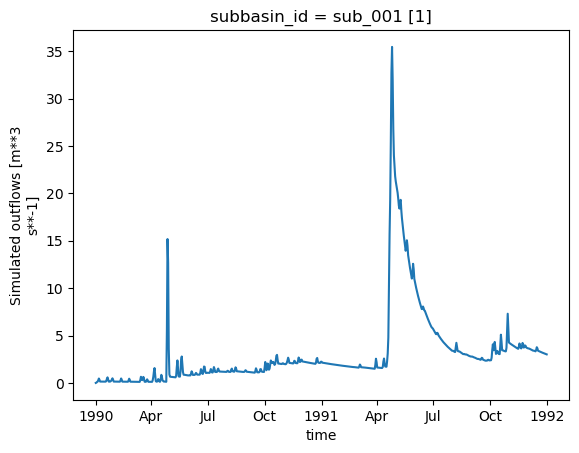

In [17]:
ht.get_streamflow()["q"].plot()

## Model Calibration

When building a model from scratch, a calibration step is necessary to find the optimal set of parameters. Model calibration involves a loop of several iterations, where: model parameters are selected, the model is run, and the results are compared to observed data. In `xHydro`, the calibration function utilizes `SPOTPY` to carry out the optimization process.

The calibration function still uses the `model_config` dictionary created earlier, but now within the `xh.modelling.perform_calibration` function.


In [18]:
help(xh.modelling.perform_calibration)

Help on function perform_calibration in module xhydro.modelling.calibration:

perform_calibration(model_config: dict, obj_func: str, bounds_high: numpy.ndarray | list[float | int], bounds_low: numpy.ndarray | list[float | int], evaluations: int, qobs: os.PathLike | numpy.ndarray | xarray.core.dataset.Dataset | xarray.core.dataarray.DataArray, algorithm: str = 'DDS', mask: numpy.ndarray | list[float | int] | None = None, transform: str | None = None, epsilon: float = 0.01, sampler_kwargs: dict | None = None)
    Perform calibration using SPOTPY.

    This is the entrypoint for the model calibration. After setting-up the
    model_config object and other arguments, calling "perform_calibration" will
    return the optimal parameter set, objective function value and simulated
    flows on the calibration period.

    Parameters
    ----------
    model_config : dict
        The model configuration object that contains all info to run the model.
        The model function called to run thi

We can prepare the additional arguments required by the calibration function. A good calibration process should always exclude some data from the computation of the objective function to ensure a validation period. This can be achieved using the `mask` argument, which uses an array of 0 and 1. 

This example will only use 10 evaluations to cut on computing time, but a real calibration should rely on at least 500 iterations with simple models such as GR4JCN.

In [19]:
qobs_file = D.fetch("ravenpy/Debit_Riviere_Rouge.nc")
ds_obs = xr.open_dataset(qobs_file)

# Reformat the data
ds_obs = ds_obs.rename({"qobs": "q"}).sel(time=slice("1990", "1991"))

# Create the mask
mask = xr.where(ds_obs.time.dt.year.isin([1990]), 0, 1)

In [20]:
# Parameter bounds for GR4JCN
bounds_low = [0.01, -15.0, 10.0, 0.0, 1.0, 0.0]
bounds_high = [2.5, 10.0, 700.0, 7.0, 30.0, 1.0]

In [21]:
# Run the calibration
best_parameters, best_simulation, best_objfun = xhm.perform_calibration(
    model_config,
    obj_func="kge",
    bounds_low=bounds_low,
    bounds_high=bounds_high,
    qobs=ds_obs,
    evaluations=10,
    algorithm="DDS",
    mask=mask,
    sampler_kwargs={"trials": 1},
)

Initializing the  Dynamically Dimensioned Search (DDS) algorithm  with  10  repetitions
The objective function will be maximized
Starting the DDS algotrithm with 10 repetitions...
Finding best starting point for trial 1 using 5 random samples.
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
6 of 10, maximal objective function=-0.335609, time remaining: 00:00:01
Best solution found has obj function value of -0.28669265678485134 at 5



*** Final SPOTPY summary ***
Total Duration: 3.74 seconds
Total Repetitions: 10
Maximal objective value: -0.286693
Corresponding parameter setting:
param0: 0.614177
param1: 4.14907
param2: 177.164
param3: 2.37965
param4: 13.5217
param5: 0.896886
******************************

Best parameter set:
param0=0.6141767310228784, param1=4.149067245697514, param2=177.16377548555374, param3=2.37964913811072, param4=13.521732543118762, param5=0.8968862770411105
Run number 7 has the highest objectivefunction with: -0.2867


In [22]:
# The first output corresponds to the best set of parameters
best_parameters

[np.float64(0.6141767310228784),
 np.float64(4.149067245697514),
 np.float64(177.16377548555374),
 np.float64(2.37964913811072),
 np.float64(13.521732543118762),
 np.float64(0.8968862770411105)]

In [23]:
# The second output corresponds to the timeseries for the best set of parameters
best_simulation

<xarray.Dataset> Size: 12kB
Dimensions:      (time: 730)
Coordinates:
  * time         (time) datetime64[ns] 6kB 1990-01-01 1990-01-02 ... 1991-12-31
    subbasin_id  <U7 28B 'sub_001'
Data variables:
    q            (time) float64 6kB ...
Attributes:
    Conventions:  CF-1.6
    featureType:  timeSeries
    history:      Created on 2025-08-04T13:30:13 by Raven 4.0
    description:  Standard Output
    references:   Craig J.R. and the Raven Development Team Raven user's and ...
    model_id:     GR4JCN

In [24]:
# The second output is the value of the objective function for the best set of parameters
best_objfun

np.float64(-0.28669265678485134)